## 1. VSQL 模型简介

变分影子量子学习（Variational Shadow Quantum Learning, VSQL）是一个在监督学习框架下的量子–经典混合算法。它使用了参数化量子电路（Parameterized Quantum Circuit, PQC）和经典影子（classical shadow），和通常使用的变分量子算法（Variational Quantum Algorithm, VQA）不同的是，VSQL 只从子空间获取局部特征，而不是从整个希尔伯特空间获取特征。

## 2. 模型原理简介

VSQL 的流程图如下：

![pipeline](https://ai-studio-static-online.cdn.bcebos.com/36c5194bc48a4af88560172fdd7ec15b8fd3225c27b644acad1981046a48d1ec "VSQL 流程图")
<div style="text-align:center">VSQL 流程图</div>

其训练步骤为：

1. 将经典数据 $\mathbf{x}^i$ 编码到量子态 $\left|\mathbf{x}^i\right>$。
2. 准备一个参数化局部量子电路 $U(\mathbf{\theta})$ 并且初始化它的参数 $\mathbf{\theta}$。
3. 在前几个量子比特上作用 $U(\mathbf{\theta})$，然后通过测量局部可观测量（比如说泡利 $X\otimes X\cdots \otimes X$ 算符）来获取一个局部影子特征。
4. 每次将 $U(\mathbf{\theta})$ 向下移动一个量子比特，重复步骤3直到 $U(\mathbf{\theta})$ 作用到最后一个量子比特上。
5. 将步骤3–4中得到的所有局部影子特征传入经典 FCNN 并通过激活函数得到预测的标签 $\tilde{\mathbf{y}}^i$。对于多分类问题来说，我们使用归一化指数函数 (softmax) 作为激活函数。
6. 重复步骤3–5直到数据集内所有的数据点都经过了处理。然后计算损失函数 $\mathcal{L}(\mathbf{\theta}, \mathbf{W}, \mathbf{b})$。
7. 通过梯度下降等优化方法调整参数 $\mathbf{\theta}$、$\mathbf{W}$ 和 $\mathbf{b}$ 的值，从而最小化损失函数。这样我们就得到了优化后的模型 $\mathcal{F}$。

由于 VSQL 只获取局部影子特征，所以它可以比较容易地在有拓扑连接限制的量子设备上实现。除此之外，因为我们用同一个 $U(\mathbf{\theta})$ 来获取整个电路上的局部影子特征，所以需要训练的参数数量相对于通常使用的变分量子分类器来说大大减少。

### 2.1 局部影子电路介绍

在讲电路的细节之前，我们需要说明几个参数：
- $n$：编码后量子态的量子比特数目。
- $n_{qsc}$：量子影子电路的宽度。我们每次只在连续 $n_{qsc}$ 个量子比特上作用 $U(\mathbf{\theta})$。
- $D$：电路的深度，表示 $U(\mathbf{\theta})$ 门中某一层电路重复的次数。

这里我们给出 $n=4$、$n_{qsc}=2$ 时的一个例子：

我们首先在前两个量子比特上作用 $U(\mathbf{\theta})$，并且获取第一个影子特征 $O_1$。

![qubit0](https://ai-studio-static-online.cdn.bcebos.com/a544360d2b864cd2882c6965bf30e1a0f5fbf089173043cd95a5821b1cdbd799 "获取第一个影子特征")
<div style="text-align:center">获取第一个影子特征</div>

然后我们准备一样的输入态 $\left|\mathbf{x}^i\right>$，在中间两个量子比特上作用 $U(\mathbf{\theta})$，得到第二个影子特征 $O_2$。

![qubit1](https://ai-studio-static-online.cdn.bcebos.com/9cdb70da3e5f47c2bd089f020975a987e1348d71d724418d890591f298786d4c "获取第二个影子特征")
<div style="text-align:center">获取第二个影子特征</div>

最后，我们再准备一个一样的输入态，在最后两个量子比特上作用 $U(\mathbf{\theta})$，得到影子特征 $O_3$。这样我们就处理完了这个数据点！

![qubit2](https://ai-studio-static-online.cdn.bcebos.com/6a404995be1141bc9fd6ca36b5e394e00fbe302621c4413bbf86554de6bfc964 "获取第三个影子特征")
<div style="text-align:center">获取第三个影子特征</div>

通常来说，处理一个数据点需要重复以上步骤 $n - n_{qsc} + 1$ 次。有一点需要指出的是，在上面这个例子中我们只使用了一个影子电路，在获取这三个影子特征时我们使用同样的参数 $\mathbf{\theta}$。你可以选择增加影子电路的数量来解决更复杂的问题，这里需要注意的是不同影子电路中的参数 $\mathbf{\theta}$ 不同。  
 
在后面的 MNIST 二分类任务中，我们将使用2–局部影子电路，即 $n_{qsc}=2$。下图展示了这个影子电路的结构。

![2-local](https://ai-studio-static-online.cdn.bcebos.com/0c1035262cb64f61bd3cc87dbf53253aa6a7ecc170634c4db8dd71d576a9409c "local数为2时的影子电路结构")
<div style="text-align:center">local数为2时的影子电路结构</div>

为了增强量子电路的表达能力，我们将重复 $D$ 次虚线框中的结构。$U(\mathbf{\theta})$ 的设计并不是唯一的，这里展示的仅仅是一个例子，也可以设计别的电路结构。

## 3. 模型效果

VSQL 在 MNIST 数据集上的二分类效果如下：

![binary-classification](https://ai-studio-static-online.cdn.bcebos.com/03c38b174d0e47ae9dbeea6dfda1333d6d3aa74209594324b78c9159b72e7e8a "二分类效果图")
<div style="text-align:center">二分类效果图</div>

VSQL 在 MNIST 数据集上的十分类效果如下：

![10-classification](https://ai-studio-static-online.cdn.bcebos.com/54a0273672ad4ec5ba6b7d73b3b225f8d97380c43ceb495a82d16a258117182b "十分类效果图")
<div style="text-align:center">十分类效果图</div>

由表可见，相比于其它的量子神经网络，VSQL 可以使用很少的参数实现更高的分类准确率。而与经典神经网络相比，在十分类任务上，VSQL 也可以使用较少的参数达到相近的效果。当数据量较小时，VSQL 比经典神经网络的效果会更好。

## 4. 模型如何使用

按照如下代码来安装量桨：

In [ ]:
# 安装量桨
%pip install --user paddle-quantum
# 下载预训练模型
!wget https://release-data.cdn.bcebos.com/PaddleQuantum/vsql.pdparams -O vsql.pdparams

成功安装量桨之后，我们来加载 VSQL 模型和要预测的图片：

In [2]:
import os
import warnings

warnings.filterwarnings('ignore')
os.environ['PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION'] = 'python'

import toml
import matplotlib.pyplot as plt
from paddle_quantum.qml.vsql import inference

--2023-01-18 15:25:40--  https://ai-studio-static-online.cdn.bcebos.com/088dc9dbabf349c88d029dfd2e07827aa6e41ba958c5434bbd96bc167fc65347
Resolving ai-studio-static-online.cdn.bcebos.com (ai-studio-static-online.cdn.bcebos.com)... 112.132.208.35, 116.177.239.35, 119.188.176.35, ...
Connecting to ai-studio-static-online.cdn.bcebos.com (ai-studio-static-online.cdn.bcebos.com)|112.132.208.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 290 [image/png]
Saving to: ‘data_0.png’

data_0.png          100%[===================>]     290  --.-KB/s    in 0s      

2023-01-18 15:25:40 (5.66 KB/s) - ‘data_0.png’ saved [290/290]



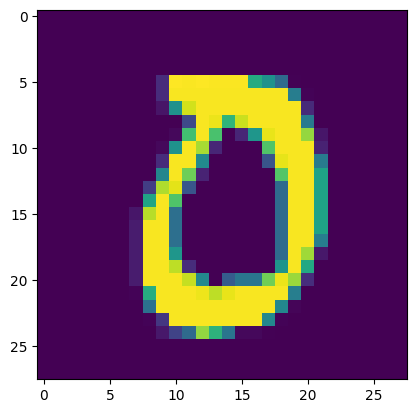

In [3]:
# 加载手写数字0
!wget https://ai-studio-static-online.cdn.bcebos.com/088dc9dbabf349c88d029dfd2e07827aa6e41ba958c5434bbd96bc167fc65347 -O data_0.png
image0 = plt.imread('data_0.png')
plt.imshow(image0)

接下来，我们来配置模型参数：

In [4]:
test_toml = r"""
# 模型的整体配置文件。
# 输入当前的任务，可以是 'train' 或者 'test'，分别代表训练和预测。这里我们使用 test，表示我们要进行预测。
task = 'test'
# 要预测的图片的文件路径。
image_path = 'data_0.png'
# 上面的图片路径是否是文件夹。对于文件夹路径，我们会对文件夹里面的所有图片文件进行预测。这种方式可以一次测试多个图片。
is_dir = false
# 训练好的模型参数文件的文件路径。
model_path = 'vsql.pdparams'
# 量子电路所包含的量子比特的数量。
num_qubits = 10
# 影子电路所包含的量子比特的数量。
num_shadow = 2
# 电路深度。
depth = 1
# 我们要预测的类别。这里我们对 0 和 1 进行分类。
classes = [0, 1]
"""

然后，我们使用 VSQL 模型来进行预测。

In [ ]:
config = toml.loads(test_toml)
task = config.pop('task')
prediction, prob = inference(**config)
prob = prob[0]
msg = '对于输入的图片，模型有'
for idx, item in enumerate(prob):
    label = config['classes'][idx]
    msg += f'{item:3.2%} 的信心认为它是 {label:d}'
    msg += '。' if idx == len(prob) - 1 else '，'
print(msg)

接下来，我们来测试另外一个图片：

--2023-01-18 15:25:46--  https://ai-studio-static-online.cdn.bcebos.com/c755f723af3d4a1c8f113f8ac3bd365406decd1be70944b7b7b9d41413e8bc7a
Resolving ai-studio-static-online.cdn.bcebos.com (ai-studio-static-online.cdn.bcebos.com)... 116.95.27.35, 116.177.239.35, 119.188.176.35, ...
Connecting to ai-studio-static-online.cdn.bcebos.com (ai-studio-static-online.cdn.bcebos.com)|116.95.27.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 173 [image/png]
Saving to: ‘data_1.png’

data_1.png          100%[===================>]     173  --.-KB/s    in 0s      

2023-01-18 15:25:46 (82.5 MB/s) - ‘data_1.png’ saved [173/173]



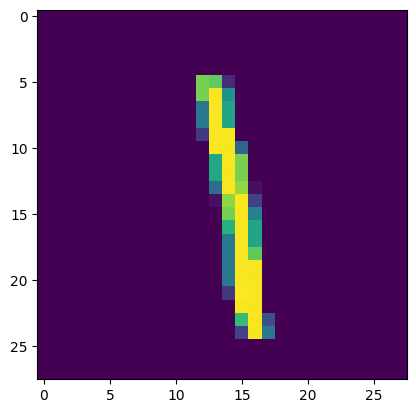

In [5]:
# 加载手写数字1
!wget https://ai-studio-static-online.cdn.bcebos.com/c755f723af3d4a1c8f113f8ac3bd365406decd1be70944b7b7b9d41413e8bc7a -O data_1.png
image1 = plt.imread('data_1.png')
plt.imshow(image1)

In [6]:
test_toml = r"""
# 模型的整体配置文件。
# 输入当前的任务，可以是 'train' 或者 'test'，分别代表训练和预测。这里我们使用 test，表示我们要进行预测。
task = 'test'
# 要预测的图片的文件路径。
image_path = 'data_1.png'
# 上面的图片路径是否是文件夹。对于文件夹路径，我们会对文件夹里面的所有图片文件进行预测。这种方式可以一次测试多个图片。
is_dir = false
# 训练好的模型参数文件的文件路径。
model_path = 'vsql.pdparams'
# 量子电路所包含的量子比特的数量。
num_qubits = 10
# 影子电路所包含的量子比特的数量。
num_shadow = 2
# 电路深度。
depth = 1
# 我们要预测的类别。这里我们对 0 和 1 进行分类。
classes = [0, 1]
"""

config = toml.loads(test_toml)
task = config.pop('task')
# 代码还需要修改
prediction, prob = inference(**config)
if config['is_dir']:
    print(f"对输入图片的预测结果分别是 {str(prediction)[1:-1]}。")
else:
    prob = prob[0]
    msg = '对于输入的图片，模型有'
    for idx, item in enumerate(prob):
        label = config['classes'][idx]
        msg += f'{item:3.2%} 的信心认为它是 {label:d}'
        msg += '。' if idx == len(prob) - 1 else '，'
    print(msg)

对于输入的图片，模型有18.29% 的信心认为它是 0，81.71% 的信心认为它是 1。


## 5. 注意事项

我们提供的模型为二分类模型，仅可以用来分辨手写数字0和1。对于其它分类任务，需要重新进行训练。

更详细的使用介绍可以参考：https://github.com/PaddlePaddle/Quantum/blob/master/applications/handwritten_digits_classification/introduction_cn.ipynb

VSQL 模型的具体介绍可以参考：https://github.com/PaddlePaddle/Quantum/blob/master/tutorials/machine_learning/VSQL_CN.ipynb

## 6. 相关论文以及引用信息

```
@inproceedings{li2021vsql,
  title={VSQL: Variational shadow quantum learning for classification},
  author={Li, Guangxi and Song, Zhixin and Wang, Xin},
  booktitle={Proceedings of the AAAI Conference on Artificial Intelligence},
  volume={35},
  number={9},
  pages={8357--8365},
  year={2021}
}
```